# Developing an AI application to identify painting style

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import numpy as np
import time
import json
import random
#import workspace_utils
from collections import OrderedDict
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

### Data exploration

#### Dataframe

Explore the dataframe with information on the paintings, we want to filter on the paitings that are present in our dataset of images and narrow down to styles that have enough paintings

In [2]:
# load the dataframe
df = pd.read_csv('all_data_info.csv')

In [3]:
df.head()

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


In [4]:
# filter on filename starting with 1 to match with training data
df_short = df[df['new_filename'].str.startswith('1')]

In [5]:
# sort by filename
df_short['sort'] = df_short['new_filename'].str.extract('(\d+)', expand=False).astype(int)
df_short.sort_values('sort',inplace=True, ascending=True)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
# filter for style with more than 400 paintings
styles = df_short['style'].value_counts()[df_short['style'].value_counts() > 400].index
df_short = df_short[df_short['style'].isin(styles)]

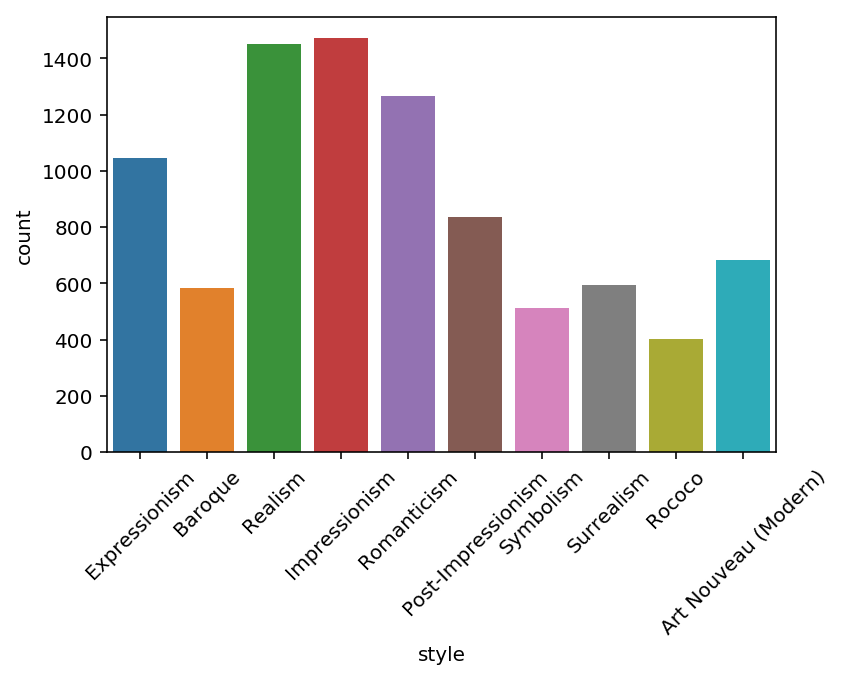

In [7]:
g = sns.countplot(x='style', data = df_short)
for item in g.get_xticklabels():
    item.set_rotation(45)

In [8]:
df_short['style'].value_counts()

Impressionism           1473
Realism                 1451
Romanticism             1267
Expressionism           1047
Post-Impressionism       838
Art Nouveau (Modern)     682
Surrealism               593
Baroque                  585
Symbolism                512
Rococo                   401
Name: style, dtype: int64

### Preparation of the data to train the model

#### Split training, validation and test set

In [9]:
# Split train and test
df_train, df_test = train_test_split(df_short, 
                                        test_size = 0.4, 
                                        random_state = 42)

# Split validation and test

In [10]:
df_validation, df_test = train_test_split(df_test, 
                                        test_size = 0.5, 
                                        random_state = 42)

In [11]:
df_train.head()

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename,sort
65556,Ilya Repin,NaN,genre painting,1000.0,486.0,101419.0,wikiart,Realism,Young ladys walk among herd of cow,train_and_test,True,14384.jpg,14384
74450,Thomas Jones,1872.0,landscape,706.0,562.0,578695.0,wikiart,Romanticism,The Grotto at Posillipo,test_only,False,17020.jpg,17020
83903,Caspar David Friedrich,NaN,landscape,484.0,600.0,51753.0,wikipedia,Romanticism,Churchyard Gate,train_and_test,True,15006.jpg,15006
33789,Zdislav Beksinski,NaN,symbolic painting,831.0,1089.0,264638.0,wikiart,Surrealism,Untitled,train_and_test,True,14306.jpg,14306
5125,John Everett Millais,1860.0,genre painting,1768.0,2672.0,838816.0,wikiart,Romanticism,The Black Brunswicker,train_and_test,True,15032.jpg,15032


#### Classify images in appropriate folders

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
%ls

README.md          checkpoint3.pth  get_started_workspace.ipynb  train_1.zip
all_data_info.csv  checkpoint4.pth  painting_classifier.ipynb


In [3]:
data_dir = '/floyd/input/paiting_kaggle/'
train_dir = data_dir+'training'
valid_dir = data_dir+'validation'
test_dir = data_dir+'test'

In [4]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([
                                        transforms.RandomRotation(30),
                                        transforms.RandomResizedCrop(224),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])


# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)


# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

In [5]:
print('Number of examples for train is {}, valid {}, test {}'.format(len(train_data), len(valid_data), len(test_data)))

Number of examples for train is 3383, valid 1148, test 1132


In [6]:
# subset of training and validation
train_subset_indices = random.sample(range(0, len(train_data)), 800)
subset_trainloader = torch.utils.data.DataLoader(train_data, batch_size=32,\
                                            sampler=torch.utils.data.SubsetRandomSampler(train_subset_indices))

valid_subset_indices = random.sample(range(0, len(valid_data)), 200)
subset_validloader = torch.utils.data.DataLoader(valid_data, batch_size=32,\
                                            sampler=torch.utils.data.SubsetRandomSampler(valid_subset_indices))

test_subset_indices = random.sample(range(0, len(test_data)), 200)
subset_testloader = torch.utils.data.DataLoader(test_data, batch_size=32,\
                                            sampler=torch.utils.data.SubsetRandomSampler(test_subset_indices))


In [7]:
class_to_idx = train_data.class_to_idx

In [8]:
class_to_idx

{'Art Nouveau (Modern)': 0,
 'Baroque': 1,
 'Expressionism': 2,
 'Impressionism': 3,
 'Post-Impressionism': 4,
 'Rococo': 5,
 'Romanticism': 6,
 'Surrealism': 7,
 'Symbolism': 8}

### Label mapping

We need a mapping from category label to category name

In [9]:
cat_to_name = {v: k for k, v in class_to_idx.items()}

# Building and training the classifier


In [23]:
def build_model_vgg(class_to_idx,
                   hidden_units=12595,
                   input_size=25088,
                   output_size=9,
                   dropout = 0.5):
    # loading vgg network
    model = models.vgg19(pretrained=True) 
    
    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
        
    #classifier
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(input_size, hidden_units)),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(p=dropout)),
                          ('fc2', nn.Linear(hidden_units, output_size)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
    model.classifier = classifier
    model.class_to_idx = class_to_idx
    
    return model

In [24]:
# hyperparameters
hidden_units = 12595
input_size=25088
output_size=9
dropout = 0.5
learning_rate = 0.002

In [25]:
# create the model
model = build_model_vgg(class_to_idx, hidden_units, input_size,output_size, dropout)
model

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:11<00:00, 48268323.90it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [26]:
# Implement a function for the validation pass
def validation(model, validloader, criterion):
    test_loss = 0
    accuracy = 0
    total = 0
    correct = 0

    for (inputs, labels) in validloader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        output = model.forward(inputs)
        test_loss += criterion(output, labels).item()

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = (100 * correct / total)
        
    
    return test_loss, accuracy

In [27]:
# define criterion and optimizer

    
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=learning_rate, momentum = 0.9)

# train the network
epochs = 3
print_every = 20
steps = 0

## change to cuda
model.to('cuda')

for e in range(epochs):
    running_loss = 0
    for ii, (inputs, labels) in enumerate(subset_trainloader):
        steps += 1

        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        optimizer.zero_grad()

        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            model.eval() # This moves your model to evaluation mode
            with torch.no_grad(): #This turns off gradients during evaluation which is faster and saves memory 
                validation_loss, val_accuracy = validation(model, subset_validloader, criterion)
                training_loss, train_accuracy = validation(model, subset_trainloader, criterion)
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Train Loss: {:.4f}".format(training_loss/print_every),
                  "Train accuracy: {:.4f}".format(train_accuracy),
                  "Valid Loss: {:.4f}".format(validation_loss/print_every),
                  "Valid accuracy: {:.4f}".format(val_accuracy))

            running_loss = 0

Epoch: 1/3...  Train Loss: 2.2610 Train accuracy: 36.0000 Valid Loss: 0.6840 Valid accuracy: 27.0000
Epoch: 2/3...  Train Loss: 1.9504 Train accuracy: 45.7500 Valid Loss: 0.6075 Valid accuracy: 37.0000
Epoch: 3/3...  Train Loss: 1.8253 Train accuracy: 46.7500 Valid Loss: 0.6409 Valid accuracy: 37.5000


# Error Analysis

### Create a custom dataset class

In [12]:
# custom class to get filename back

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [18]:
# instantiate the dataset which is a subset of the validation set
data_dir = "/floyd/input/paiting_kaggle/validation_error/"
dataset = ImageFolderWithPaths(data_dir, transform=valid_transforms) # our custom dataset
error_validloader = torch.utils.data.DataLoader(dataset, batch_size=32)

('/floyd/input/paiting_kaggle/validation_error/Art Nouveau (Modern)/100062.jpg', '/floyd/input/paiting_kaggle/validation_error/Art Nouveau (Modern)/100261.jpg', '/floyd/input/paiting_kaggle/validation_error/Art Nouveau (Modern)/102926.jpg', '/floyd/input/paiting_kaggle/validation_error/Art Nouveau (Modern)/12362.jpg', '/floyd/input/paiting_kaggle/validation_error/Art Nouveau (Modern)/12862.jpg', '/floyd/input/paiting_kaggle/validation_error/Art Nouveau (Modern)/13244.jpg', '/floyd/input/paiting_kaggle/validation_error/Art Nouveau (Modern)/13655.jpg', '/floyd/input/paiting_kaggle/validation_error/Art Nouveau (Modern)/16759.jpg', '/floyd/input/paiting_kaggle/validation_error/Art Nouveau (Modern)/17635.jpg', '/floyd/input/paiting_kaggle/validation_error/Art Nouveau (Modern)/18186.jpg', '/floyd/input/paiting_kaggle/validation_error/Art Nouveau (Modern)/18797.jpg', '/floyd/input/paiting_kaggle/validation_error/Baroque/101230.jpg', '/floyd/input/paiting_kaggle/validation_error/Baroque/102030

In [ ]:
preds_tot = np.array([])
labels_tot = np.array([])
paths_tot = []
i = 0

# iterate over data    
with torch.no_grad():
    for (inputs, labels, paths) in error_validloader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        preds = predicted.cpu().numpy()
        labs = labels.cpu().numpy()
        preds_tot = np.hstack((preds_tot, preds))
        labels_tot = np.hstack((labels_tot, labs))
        paths_tot.append(paths)
        i += 1

In [ ]:
# dataframe with results
error_analysis = pd.DataFrame(paths_tot)
error_analysis['labels'] = list(labels_tot)
error_analysis['preds'] = list(preds_tot)

# write to csv
error_analysis.to_csv('error_analysis.csv')

In [ ]:
# load file 
error_analysis = pd.read_csv('error_analysis.csv')

### Confusion matrix

In [ ]:
preds_tot = np.array([])
labels_tot = np.array([])
i = 0
with torch.no_grad():
    for (inputs, labels) in subset_validloader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        preds = predicted.cpu().numpy()
        labs = labels.cpu().numpy()
        preds_tot = np.hstack((preds_tot, preds))
        labels_tot = np.hstack((labels_tot, labs))
        i += 1

In [29]:
cnf_matrix = confusion_matrix(labels_tot, preds_tot, labels = [0,1,2,3,4,5,6,7,8])

In [30]:
cnf_matrix

array([[ 3,  1,  6,  3,  0,  0,  2,  0,  0],
       [ 0,  9,  0,  1,  0,  0,  5,  0,  0],
       [ 1,  0, 17,  3,  2,  0,  1,  0,  0],
       [ 1,  3,  1, 26,  0,  0,  5,  0,  0],
       [ 0,  0,  7, 10,  4,  0,  3,  0,  0],
       [ 0,  6,  1,  0,  0,  0,  8,  0,  0],
       [ 0,  6,  1, 12,  2,  0, 15,  3,  0],
       [ 1,  0,  3,  2,  0,  0,  4,  5,  0],
       [ 1,  0,  4,  8,  0,  0,  2,  2,  0]])

In [19]:
styles = list(class_to_idx.keys())

In [ ]:
cnf_matrix_df = pd.DataFrame(cnf_matrix)
cnf_matrix_df.columns = styles

In [ ]:
cnf_matrix_df

## Testing your network


In [37]:
correct = 0
total = 0
with torch.no_grad():
    for (inputs, labels) in subset_testloader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 38 %


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [38]:
def save_checkpoint(filepath, model, learning_rate, hidden_units):
    network= {
            'arch': 'vgg19',
            'learning_rate': learning_rate,
            'hidden': hidden_units,
            'state_dict': model.state_dict(),
            'class_to_idx': model.class_to_idx}

    torch.save(network, filepath)

In [39]:
save_checkpoint('checkpoint4.pth', model, learning_rate, hidden_units)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [14]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    
    learning_rate = checkpoint['learning_rate']
    hidden_units = checkpoint['hidden']
    class_to_idx = checkpoint['class_to_idx']
    
    model = build_model_vgg(class_to_idx,
                   hidden_units)
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, learning_rate, hidden_units

In [15]:
model, learning_rate, hidden_units = load_checkpoint('checkpoint3.pth')
model.classifier

Sequential(
  (fc1): Linear(in_features=25088, out_features=12595, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=12595, out_features=102, bias=True)
  (output): LogSoftmax()
)

# Inference for classification


## Image Preprocessing


In [33]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''                       
    
    # TODO: Process a PIL image for use in a PyTorch model
    pil_image = Image.open(image_path)
    
    width, height = pil_image.size
    ratio = float(width/height);
        
    if height > width:
        height = int(height * 256 / width)
        width = int(256)
    else:
        width = int(width * 256 / height)
        height = int(256)
        
    resized_image = pil_image.resize((width, height), Image.ANTIALIAS)
    
    # Crop center portion of the image
    x0 = (width - 224) / 2
    y0 = (height - 224) / 2
    x1 = x0 + 224
    y1 = y0 + 224
    crop_image = resized_image.crop((x0,y0,x1, y1))
    
    # Normalize:
    np_image = np.array(crop_image) / 255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    return np_image.transpose(2,0,1)

In [34]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

Flower Class: Baroque


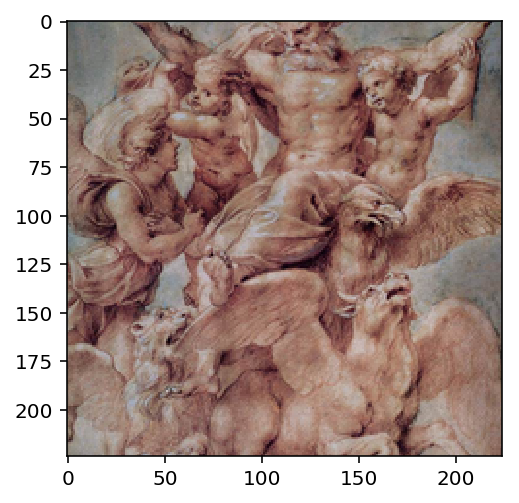

In [42]:
image_path  = 'valid/Baroque/104.jpg'
imshow(process_image(image_path))
painting = cat_to_name[1]
print("Flower Class: {}".format(painting))

## Class Prediction


In [43]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    # Calculate the class probabilities (softmax) for img
    model.eval()

    img = process_image(image_path)
    tensor_in = torch.from_numpy(img)

    tensor_in = tensor_in.float() 
    tensor_in = tensor_in.unsqueeze(0)

    model.to("cuda")
    tensor_in.to("cuda")
    
    with torch.no_grad():
        output = model.forward(tensor_in.cuda())
        
    output = torch.exp(output)
        
    topk_prob, topk_index = torch.topk(output, topk) 
    topk_prob = topk_prob.tolist()[0]
    topk_index = topk_index.tolist()[0]
    
    idx_to_cat = {value: key for key, value in model.class_to_idx.items()}
    
    top_cat = [idx_to_cat[ele] for ele in topk_index]

    return topk_prob, top_cat

In [44]:
image_path  = 'valid/Baroque/101729.jpg'
predict(image_path, model, topk=5)

([0.6991286873817444,
  0.052442777901887894,
  0.05176858231425285,
  0.05014793947339058,
  0.03866485133767128],
 ['Baroque', 'Romanticism', 'Rococo', 'Symbolism', 'Art Nouveau (Modern)'])

## Sanity Checking


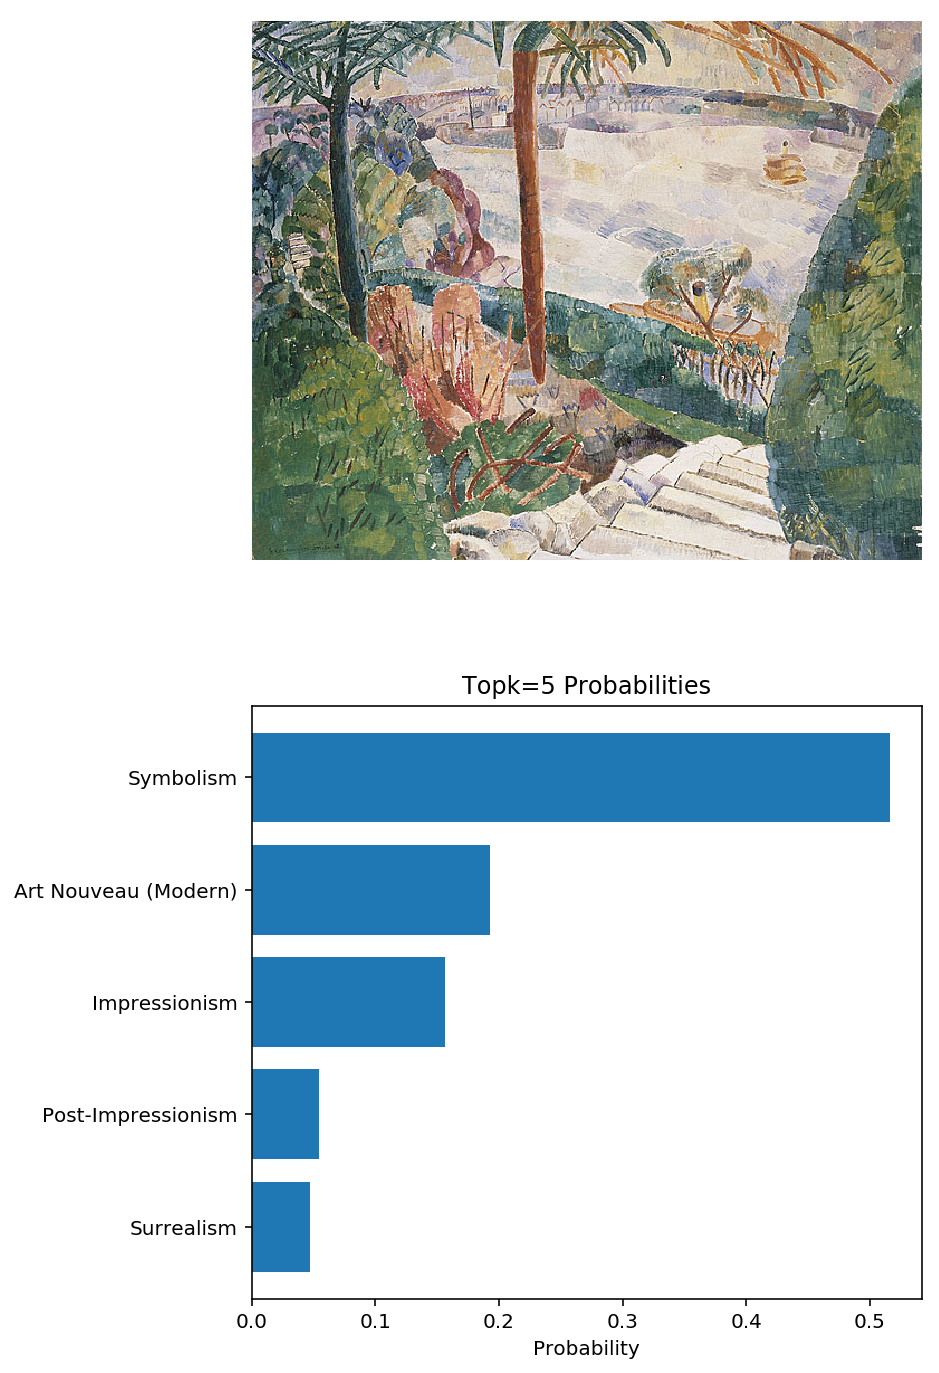

In [48]:
# TODO: Display an image along with the top 5 classes
image_path  = 'valid/Post-Impressionism/101432.jpg'

probs, classes = predict(image_path, model, topk=5)

#top_labels = [cat_to_name[cat] for cat in classes]

plt.figure(figsize=(6,12))
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

image = Image.open(image_path)
ax1.axis('off')
ax1.imshow(image)

y_pos = np.arange(5)
ax2.set_title('Topk=5 Probabilities')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(classes)
ax2.set_xlabel('Probability')
ax2.barh(y_pos, probs, align='center')
ax2.invert_yaxis()

plt.show()